## Observations
1. Our gradient estimates at known sample locations are large when we resample at the sample location in our trajectory.

In [1]:
using LinearAlgebra
using Plots
using Random

In [2]:
include("../rollout.jl")
include("../testfns.jl")
include("../utils.jl")

to (generic function with 1 method)

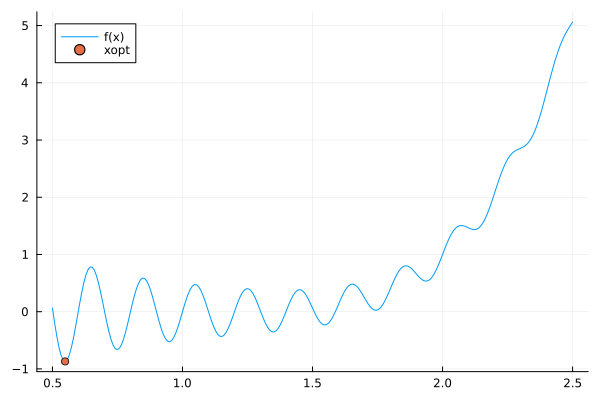

In [4]:
testfn = TestGramacyLee()
tplot(testfn)

In [6]:
Random.seed!(1906)

n, h, σn2 = 1, 0, 1e-6
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., θ...])

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 8
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [79]:
# X = [-1.;; -.99;; -.5;; .5;; .99;; 1.;;]
# X = [.5;; 1.2;; 2.1;; π - .7;;]
X = rand(2, 2)
y = testfn(X)
sur = fit_surrogate(ψ, X, y; σn2=σn2)
# sur = optimize_hypers_optim(sur, kernel_matern52)

discretization_length = 1000
domain = collect(range(xmin, xmax, length=discretization_length))
w = 1e-8 * ones(d)
variance_reduction = false

rollouts = zeros(discretization_length)
rollouts_stderr = zeros(discretization_length)
gradient_rollouts = zeros(discretization_length)
gradient_rollouts_stderr = zeros(discretization_length)
finite_difference_rollouts = zeros(discretization_length)

trajectories = []

function monitor_trajectory(t)
    push!(trajectories, t)
end

print("Rollout Evaluations: ")
# Dense Evaluation of Rollout Acquisition Function
for (i, x) in enumerate(domain)
    print("|")
    x0 = [x]
    sx = sur(x0)

    tp = TrajectoryParameters(
        x0=x0, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=lds_rns, lbs=lbs, ubs=ubs
    )
    # Monte-carlo integrate trajectory for x0
    μx, ∇μx = simulate_trajectory_deterministic(
        sur, tp, xstarts, testfn=testfn, monitor=monitor_trajectory, variance_reduction=false
    )
    rollouts[i] = μx
    gradient_rollouts[i] = first(∇μx)

    # Finite Difference Approximation of Gradients
    tp_plus = TrajectoryParameters(
        x0=x0 .+ w, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=lds_rns, lbs=lbs, ubs=ubs
    )
    tp_minus = TrajectoryParameters(
        x0=x0 .- w, h=h, mc_iters=MC_SAMPLES,
        rnstream_sequence=lds_rns, lbs=lbs, ubs=ubs
    )
    μx_plus, trash = simulate_trajectory_deterministic(
        sur, tp_plus, xstarts, testfn=testfn
    )
    μx_minus, trash = simulate_trajectory_deterministic(
        sur, tp_minus, xstarts, testfn=testfn
    )
    finite_difference_rollouts[i] = (μx_plus - μx_minus) / 2w
end

Rollout Evaluations: |n_rows => 3, n_cols => 1
d + 1 => 2, h + 1 => 1


LoadError: AssertionError: Random number stream must have d + 1 rows and h + 1 columns for each sample

In [75]:
size(lds_rns), size(rns)

((50, 3, 1), (50, 3, 1))

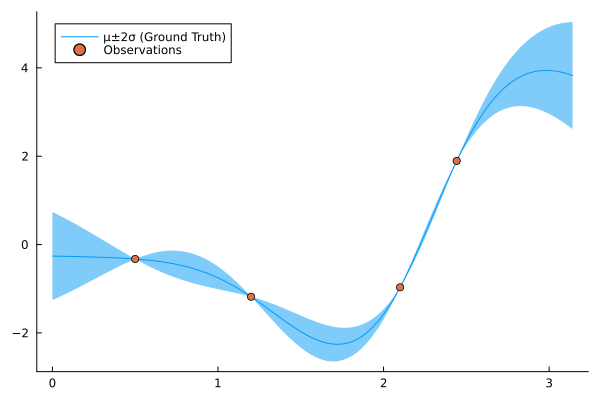

In [30]:
plot1D(sur; xmin=xmin, xmax=xmax, npts=100)
# plot!(domain, [testfn([x]) for x in domain], label="Underlying Function")

In [31]:
sample(trajectories[1][end])
α(trajectories[1][end])

0.0

In [32]:
best(trajectories[1][end])

(1, (x = [0.0], y = 0.0, ∇y = [1.0]))

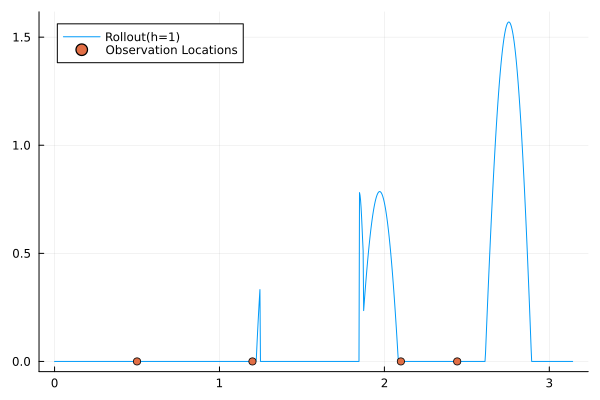

In [54]:
zero_indices_analytic = find_zeros(gradient_rollouts);
zero_indices_fd = find_zeros(finite_difference_rollouts);

# plot(domain, rollouts .+ 1e-9, label="Rollout(h=$h)", yaxis=:log)
# scatter!(sur.X', [0.] .+ 1e-9, label="Observation Locations")
plot(domain, rollouts, label="Rollout(h=$h)")
scatter!(sur.X', [0.], label="Observation Locations")
# scatter!(
#     domain[zero_indices_analytic],
#     rollouts[zero_indices_analytic],
#     label="Points of Stationarity (Analytic)",
#     legend=:outertopright,
#     size=(1400, 600),
#     color=:red,
#     ms=10
# )
# scatter!(
#     domain[zero_indices_fd],
#     rollouts[zero_indices_fd],
#     label="Points of Stationarity (Finite Difference)",
#     color=:blue,
#     ms=6
# )

In [59]:
ndx = 890
(gradient_rollouts[ndx] - finite_difference_rollouts[ndx]) / (finite_difference_rollouts[ndx])

4.993256437388521e-9

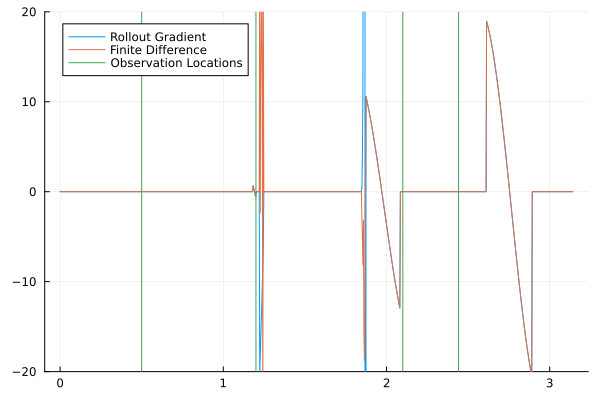

In [55]:
plot(domain, gradient_rollouts, label="Rollout Gradient", ribbons=gradient_rollouts_stderr, ylims=(-20, 20))
# scatter!(domain[zero_indices_analytic], [0], ms=4, label="Roots")
plot!(domain, finite_difference_rollouts, label="Finite Difference", ylims=(-20, 20))
# plot!(domain, [first(sur([x]).∇EI) for x in domain], label="Analytic EI", dpi=900)
# scatter!(sur.X', [0.], label="Observation Locations", markersize=2)
vline!(sur.X', label="Observation Locations", markersize=2)

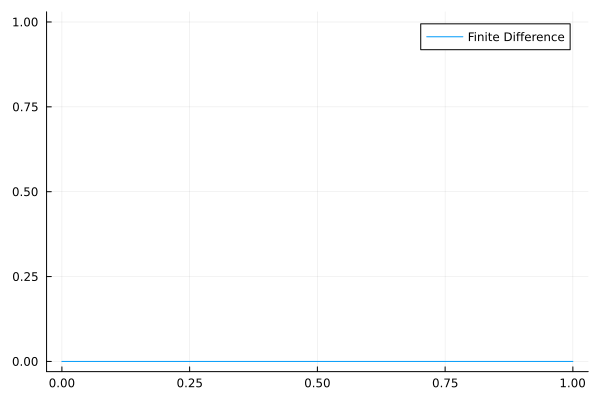

In [339]:
plot(domain, finite_difference_rollouts, label="Finite Difference")

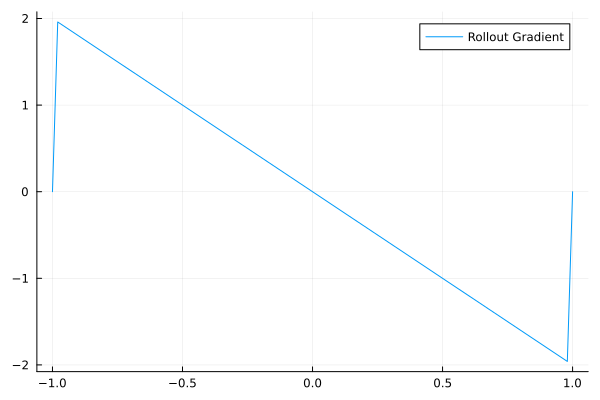

In [254]:
plot(domain, gradient_rollouts, label="Rollout Gradient")
# scatter!(domain[zero_indices_analytic], [0], ms=4, label="Roots")
# plot!(domain, finite_difference_rollouts, label="Finite Difference")
# plot!(domain, [first(sur([x]).∇EI) for x in domain], label="Analytic EI", dpi=900)
# savefig("rolloutgrad.png")

In [ ]:
"""
TODO: We need to specify the maximum number of iterations and terminate if we exhaust our budget
TODO: EI for Rosenbrock looks like zeros everywhere, depending on how we sample. I suspect this
is why our algorithm halts here.
"""
function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(df, dfc, initial_guess, IPNewton(), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

# Initialize surrogate model
Xinit = [1.5;; 2.0;;]
yinit = testfn(Xinit)
sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
BUDGET = 50
surs = []

# Perform Bayesian optimization iterations
print("Budget Counter: ")
for budget in 1:BUDGET
    print("|")
    # Solve the acquisition function
    xnext, fnext = ei_solver(sur_ei, lbs, ubs; initial_guesses=xstarts)
    ynext = testfn(xnext)
    # Update the surrogate model
    sur_ei = update_surrogate(sur_ei, xnext, ynext)
    sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
    push!(surs, sur_ei)
end

In [ ]:
plot1D(surs[3], xmin=xmin, xmax=xmax)

In [ ]:
fopt, xopt_index = findmin(get_observations(sur_ei))
sur_ei.X[:, xopt_index]

In [ ]:
sur_ei.X'

In [ ]:
testfn.xopt

In [ ]:
tplot(testfn)

In [ ]:
X = [0.;; .8;;]
npts = size(X, 2)
δXdemo = rand(1, npts)
h = 1e-5
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
∇y = [testfn.∇f(X[:,j]) for j in 1:size(X, 2)]

s  = fit_surrogate(ψ, X, y)
sp = fit_surrogate(ψ, X + h*δXdemo, y)
sm = fit_surrogate(ψ, X - h*δXdemo, y)

fs = fit_fsurrogate(s, 0)
fsp = fit_fsurrogate(sp, 0)
fsm = fit_fsurrogate(sm, 0)
δfs = fit_δsurrogate(fs, δXdemo, ∇y)

In [ ]:
plot(domain, [s([x]).EI for x in domain], label="EI")
plot!(domain, [sp([x]).EI for x in domain], label="EI + h")
plot!(domain, [sm([x]).EI for x in domain], label="EI - h")

In [ ]:
xn = [0.2712471165977242]
(fsp(xn).EI - fsm(xn).EI) / 2h

In [ ]:
fsx = fs(xn)
δfsx = δfs(fsx);
δfsx.EI

In [ ]:
xopt, _ = ei_solver(s, lbs, ubs; initial_guesses=xstarts)
xoptp, _ = ei_solver(sp, lbs, ubs; initial_guesses=xstarts)
xoptm, _ = ei_solver(sm, lbs, ubs; initial_guesses=xstarts)

In [ ]:
(xoptp - xoptm) / 2h

In [ ]:
-fsx.HEI \ δfsx.∇EI

In [ ]:
δfs.ymean

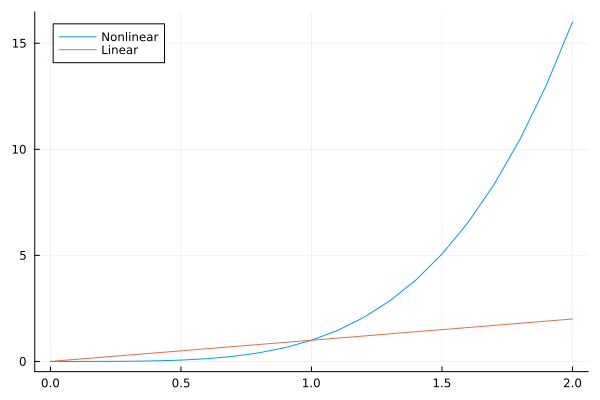

In [71]:
domain = 0:.1:2.
f(x) = x^4
g(x) = x
plot(domain, f.(domain), label="Nonlinear")
plot!(domain, g.(domain), label="Linear")